# Second attempt to model the zri

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from google.cloud import bigquery
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="adept-comfort-307720-db5f8ca3ee46.json"
client = bigquery.Client()

import seaborn as sns

### Predictors

In [3]:
%load_ext google.cloud.bigquery

In [133]:
%%bigquery acs_zip

SELECT  geo_id, do_date, total_pop, households, median_income ,
        income_per_capita, gini_index, percent_income_spent_on_rent,
        hispanic_pop, black_pop , unemployed_pop,
        pop_determined_poverty_status, poverty    
FROM `bigquery-public-data.census_bureau_acs.zip_codes_2015_5yr`
UNION ALL
SELECT  geo_id, do_date, total_pop, households, median_income ,
        income_per_capita, gini_index, percent_income_spent_on_rent,
        hispanic_pop, black_pop , unemployed_pop,
        pop_determined_poverty_status, poverty    
FROM `bigquery-public-data.census_bureau_acs.zip_codes_2016_5yr`
UNION ALL
SELECT  geo_id, do_date, total_pop, households, median_income ,
        income_per_capita, gini_index, percent_income_spent_on_rent,
        hispanic_pop, black_pop , unemployed_pop,
        pop_determined_poverty_status, poverty    
FROM `bigquery-public-data.census_bureau_acs.zip_codes_2017_5yr`
ORDER BY do_date;

Downloading: 100%|██████████| 99360/99360 [00:03<00:00, 29291.30rows/s]


In [134]:
acs_zip.describe()

,total_pop,households,median_income,income_per_capita,gini_index,percent_income_spent_on_rent,hispanic_pop,black_pop,unemployed_pop,pop_determined_poverty_status,poverty
count,99360.000000,99360.000000,93135.000000,97535.000000,96742.000000,83166.000000,99360.000000,99360.000000,99360.000000,99360.000000,99360.000000
mean,9728.406512,3594.677486,54958.751651,27752.976214,0.414237,28.886942,1775.327114,1180.888275,364.320199,9488.366204,1459.988335
std,14369.441169,5168.354396,23336.121613,12831.297382,0.074746,7.901708,5846.460313,3775.379128,640.210960,14119.338892,2835.771179
min,0.000000,0.000000,2499.000000,6.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,714.000000,272.000000,40329.000000,20567.000000,0.377600,24.000000,7.000000,0.000000,17.000000,678.000000,78.750000
50%,2807.000000,1060.000000,50500.000000,25282.000000,0.416000,28.400000,82.000000,28.000000,86.000000,2704.000000,335.000000
75%,13194.000000,4963.000000,63750.000000,31598.000000,0.456200,33.000000,775.250000,563.000000,426.000000,12810.250000,1490.000000
max,119204.000000,43456.000000,250001.000000,465868.000000,0.848300,50.000000,103342.000000,85426.000000,9735.000000,118818.000000,43801.000000


In [135]:
acs_zip['poverty_rate'] = acs_zip['poverty']/acs_zip['pop_determined_poverty_status']
acs_zip['hispanic_pop_perc'] = acs_zip['hispanic_pop'] *100 / acs_zip['total_pop']
acs_zip['black_pop_perc'] = acs_zip['black_pop'] *100 / acs_zip['total_pop']
acs_zip = acs_zip.drop(columns = ['households','income_per_capita',
                                 'poverty', 'hispanic_pop','black_pop',
                                 'pop_determined_poverty_status'])

In [136]:
cols = acs_zip.columns
acs_zip[cols] = acs_zip[cols].apply(pd.to_numeric, errors='coerce')

In [137]:
acs_zip.describe()

,geo_id,do_date,total_pop,median_income,gini_index,percent_income_spent_on_rent,unemployed_pop,poverty_rate,hispanic_pop_perc,black_pop_perc
count,99360.000000,9.936000e+04,99360.000000,93135.000000,96742.000000,83166.000000,99360.000000,97791.000000,98412.000000,98412.000000
mean,49666.334209,2.012202e+07,9728.406512,54958.751651,0.414237,28.886942,364.320199,0.151513,9.284402,7.492530
std,27564.648340,8.165823e+03,14369.441169,23336.121613,0.074746,7.901708,640.210960,0.120106,16.711602,15.743518
min,601.000000,2.011202e+07,0.000000,2499.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000
25%,26634.750000,2.011202e+07,714.000000,40329.000000,0.377600,24.000000,17.000000,0.071756,0.633707,0.000000
50%,49739.000000,2.012202e+07,2807.000000,50500.000000,0.416000,28.400000,86.000000,0.125419,2.985529,0.861714
75%,72123.500000,2.013202e+07,13194.000000,63750.000000,0.456200,33.000000,426.000000,0.199451,9.172477,6.207311
max,99929.000000,2.013202e+07,119204.000000,250001.000000,0.848300,50.000000,9735.000000,1.000000,100.000000,100.000000


In [138]:
nulls = acs_zip.isnull().sum(axis = 0)
nulls[nulls>1].sort_values()

hispanic_pop_perc                 948
black_pop_perc                    948
poverty_rate                     1569
gini_index                       2618
median_income                    6225
percent_income_spent_on_rent    16194
dtype: int64

In [141]:
%%bigquery area_zip

SELECT  zip_code, area_land_meters, area_water_meters

FROM `bigquery-public-data.geo_us_boundaries.zip_codes`


Downloading: 100%|██████████| 33113/33113 [00:02<00:00, 14325.78rows/s]


In [144]:
print(area_zip.shape)
print(acs_zip.shape)

(33113, 3)
(99360, 10)


In [146]:
cols = area_zip.columns
area_zip[cols] = area_zip[cols].apply(pd.to_numeric, errors='coerce')

In [189]:
predictors = pd.merge(acs_zip, area_zip, how = 'left', left_on = 'geo_id',
                      right_on = 'zip_code')
predictors.sample(5)

,geo_id,do_date,total_pop,median_income,gini_index,percent_income_spent_on_rent,unemployed_pop,poverty_rate,hispanic_pop_perc,black_pop_perc,zip_code,area_land_meters,area_water_meters
79673,81654,20132017,1520.0,50417.0,0.5294,35.8,90.0,0.072938,45.263158,0.000000,81654.0,228627129.0,892553.0
22492,90210,20112015,22052.0,145227.0,0.6190,27.4,681.0,0.081010,6.289679,1.351351,90210.0,26222771.0,153478.0
56711,62025,20122016,34151.0,71580.0,0.4509,32.2,1269.0,0.115616,2.222483,7.633744,62025.0,282309696.0,4713307.0
12261,45335,20112015,6682.0,53141.0,0.3981,28.5,277.0,0.097820,1.032625,0.434002,45335.0,219894420.0,955448.0
52763,26142,20122016,2806.0,49318.0,0.4284,19.5,183.0,0.127770,3.421240,4.205274,26142.0,32868713.0,449706.0


In [190]:
predictors['pop_density'] = predictors['total_pop']/predictors['area_land_meters']
predictors['water_land_ratio'] = predictors['area_water_meters']/predictors['area_land_meters']
predictors = predictors.drop( columns = ['total_pop', 'area_land_meters',
                                         'area_water_meters'])

In [191]:
predictors.sample(10)

,geo_id,do_date,median_income,gini_index,percent_income_spent_on_rent,unemployed_pop,poverty_rate,hispanic_pop_perc,black_pop_perc,zip_code,pop_density,water_land_ratio
92115,18603,20132017,45865.0,0.4267,30.7,683.0,0.164020,5.816601,1.474850,18603.0,1.445665e-04,0.029424
1699,54651,20112015,43319.0,0.3843,29.1,34.0,0.263514,8.841010,0.000000,54651.0,8.990365e-06,0.001962
15381,58381,20112015,61944.0,0.5693,13.0,1.0,0.267606,0.000000,0.000000,58381.0,7.307195e-07,0.072024
41542,15530,20122016,46977.0,0.3743,25.5,189.0,0.135309,1.582815,0.226116,15530.0,2.342041e-05,0.000379
28787,32147,20112015,17063.0,0.3954,NaN,11.0,0.635514,0.000000,0.000000,32147.0,4.844537e-06,0.004260
13790,46030,20112015,54868.0,0.4148,23.9,125.0,0.130045,0.693132,0.441084,46030.0,3.280286e-05,0.009219
95460,41833,20132017,32481.0,0.3625,NaN,7.0,0.179130,0.000000,0.000000,41833.0,1.384192e-05,0.002607
1738,49287,20112015,65924.0,0.3630,50.0,47.0,0.040318,2.122016,0.000000,49287.0,2.585944e-05,0.020074
21515,34639,20112015,65766.0,0.3756,28.2,905.0,0.052817,19.275379,6.656581,34639.0,3.716624e-04,0.062242
78112,87558,20132017,37679.0,0.3991,26.7,0.0,0.101852,4.398148,0.000000,87558.0,1.315853e-06,0.000356


In [193]:
predictors['do_date'].value_counts()

20132017    33120
20112015    33120
20122016    33120
Name: do_date, dtype: int64

In [156]:
predictors['year'] = np.where(predictors['do_date'] == 20132017, '2017',
                                 np.where(predictors['do_date'] == 20112015, '2015', '2016'))

In [160]:
predictors = predictors.drop(columns = 'do_date')

In [167]:
predictors['zip_code'] = predictors['zip_code'].astype('string')

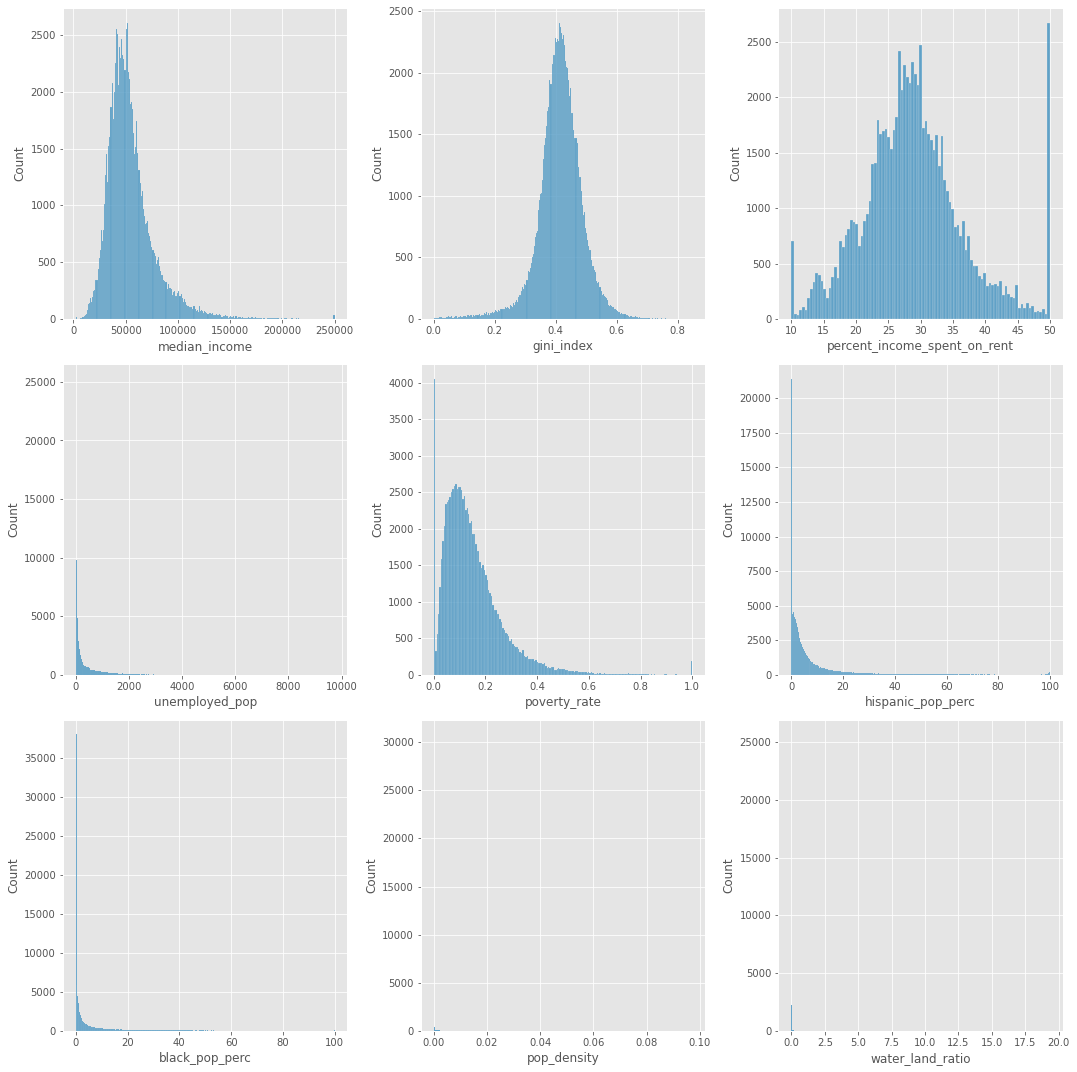

In [186]:
f, axes = plt.subplots(3, 3, figsize=(15,15))

sns.histplot( x= "median_income", data=predictors,  ax=axes[0,0])
sns.histplot( x= "gini_index", data=predictors,  ax=axes[0,1])
sns.histplot( x= "percent_income_spent_on_rent", data=predictors,  ax=axes[0,2])
sns.histplot( x= "unemployed_pop", data=predictors,  ax=axes[1,0])
sns.histplot( x= "poverty_rate", data=predictors,  ax=axes[1,1])
sns.histplot( x= "hispanic_pop_perc", data=predictors,  ax=axes[1,2])
sns.histplot( x= "black_pop_perc", data=predictors,  ax=axes[2,0])
sns.histplot( x= "pop_density", data=predictors,  ax=axes[2,1])
sns.histplot( x= "water_land_ratio", data=predictors,  ax=axes[2,2])
plt.tight_layout();

(0.0, 300.0)

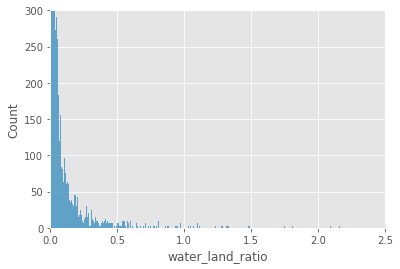

In [185]:
sns.histplot( x= "water_land_ratio", data=predictors)
plt.xlim(0,2.5)
plt.ylim(0,300)

### Label

In [55]:
zri_all = pd.read_csv('./data/Zip_Zri_AllHomesPlusMultifamily.csv')
zri_all.head() 

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01
0,61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,3031.0,3058.0,3031.0,3015.0,2976.0,2914.0,2860.0,2811.0,2792.0,2799.0,2820.0,2852.0,2885.0,2905.0,2883.0,2879.0,2905.0,2916.0,2908.0,2915.0,2920.0,2920.0,2938.0,2999.0,3029.0,3022.0,3049.0,3083.0,3086.0,3072.0,3081.0,3095.0,3147.0,3190.0,3188.0,3149.0,3149.0,3174.0,3175.0,3230.0,3267.0,3285.0,3234.0,3296.0,3357.0,3366.0,NaN,3186.0,3204.0,NaN,NaN,NaN,3682.0,3767.0,3767.0,3811.0,3793.0,3894.0,3919.0,NaN,NaN,NaN,NaN,4166.0,4164.0,4133.0,4015.0,3943.0,3945.0,4051.0,NaN,NaN,NaN,NaN,4916.0,NaN,5009.0,NaN,NaN,NaN,NaN,3988.0,NaN,NaN,3661.0,NaN,NaN,NaN,NaN,3512.0,3552.0,NaN,3768.0,3731.0,3634.0,NaN,NaN,3300.0,3227.0,NaN,NaN,NaN,NaN,3785.0,3788.0,3786.0,3784.0,3766.0,3779.0,3843.0,3873.0,3835.0,NaN
1,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2,1790.0,1787.0,1784.0,1774.0,1755.0,1742.0,1735.0,1741.0,1742.0,1757.0,1790.0,1817.0,1839.0,1841.0,1844.0,1844.0,1820.0,1818.0,1829.0,1843.0,1860.0,1878.0,1898.0,1889.0,1890.0,1894.0,1897.0,1886.0,1884.0,1887.0,1907.0,1918.0,1925.0,1948.0,1996.0,2017.0,2011.0,2002.0,1989.0,1984.0,1979.0,1976.0,1969.0,1989.0,1996.0,2001.0,2006.0,2009.0,2032.0,2045.0,2038.0,2028.0,2016.0,2028.0,2033.0,2027.0,2041.0,2071.0,2100.0,2136.0,2139.0,2119.0,2093.0,2079.0,2061.0,2058.0,2079.0,2100.0,2115.0,2150.0,2184.0,2201.0,2212.0,2207.0,2182.0,2136.0,2108.0,2104.0,2117.0,2118.0,2125.0,2146.0,2168.0,2183.0,2165.0,2128.0,2097.0,2070.0,2057.0,2052.0,2054.0,2061.0,2074.0,2106.0,2134.0,2146.0,2155.0,2149.0,2116.0,2076.0,2025.0,2014.0,2017.0,2039.0,2070.0,2105.0,2140.0,2168.0,2185.0,2125.0,NaN,2053.0,1996.0
2,61637,10023,New York,NY,New York-Newark-Jersey City,New York County,3,3269.0,3304.0,3320.0,3322.0,3283.0,3225.0,3133.0,3086.0,3017.0,3005.0,3010.0,3016.0,3028.0,3069.0,3020.0,2999.0,2988.0,3023.0,3037.0,3055.0,3069.0,3058.0,3065.0,3104.0,3117.0,3118.0,3124.0,3128.0,3098.0,3078.0,3119.0,3150.0,3183.0,3227.0,3233.0,3199.0,3217.0,3255.0,3274.0,3346.0,3357.0,3363.0,3287.0,3312.0,3385.0,3385.0,NaN,3231.0,3258.0,NaN,NaN,NaN,NaN,4011.0,3985.0,4026.0,4012.0,NaN,NaN,NaN,NaN,NaN,NaN,4734.0,4800.0,4690.0,4693.0,NaN,4418.0,4534.0,NaN,4753.0,4687.0,4788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4176.0,NaN,3997.0,3924.0,NaN,NaN,NaN,NaN,3802.0,3809.0,3900.0,3999.0,4043.0,3957.0,NaN,NaN,3611.0,3560.0,NaN,NaN,NaN,3928.0,3874.0,3898.0,3917.0,3929.0,3931.0,3963.0,NaN,4123.0,4079.0,NaN
3,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,1547.0,1549.0,1560.0,1560.0,1542.0,1547.0,1559.0,1578.0,1591.0,1597.0,1604.0,1609.0,1607.0,1598.0,1591.0,1591.0,1606.0,1614.0,1617.0,1612.0,1611.0,1617.0,1630.0,1640.0,1649.0,1655.0,1658.0,1658.0,1661.0,1675.0,1698.0,1727.0,1753.0,1771.0,1789.0,1808.0,1852.0,1882.0,1906.0,1920.0,1930.0,1936.0,1931.0,1925.0,1929.0,1935.0,1953.0,1967.0,1984.0,1994.0,1999.0,1999.0,1945.0,1917.0,1906.0,1903.0,1908.0,1919.0,1933.0,1944.0,1931.0,1924.0,1918.0,1915.0,1881.0,1859.0,1839.0,1828.0,1827.0,1826.0,1830.0,1826.0,1801.0,1782.0,1772.0,1767.0,1765.0,1763.0,1762.0,1760.0,1752.0,1753.0,1757

In [56]:
columns2015 = ['2015-01','2015-02','2015-03','2015-04','2015-05','2015-06','2015-07',
              '2015-07','2015-08','2015-09','2015-10','2015-11','2015-12']
mean_2015_all = []
for row in range(zri_all.shape[0]):
    mean_2015_all.append(np.mean(zri_all.loc[row, columns2015]))

columns2016 = ['2016-01','2016-02','2016-03','2016-04','2016-05','2016-06','2016-07',
              '2016-07','2016-08','2016-09','2016-10','2016-11','2016-12']
mean_2016_all = []
for row in range(zri_all.shape[0]):
    mean_2016_all.append(np.mean(zri_all.loc[row, columns2016]))
    
columns2017 = ['2017-01','2017-02','2017-03','2017-04','2017-05','2017-06','2017-07',
              '2017-07','2017-08','2017-09','2017-10','2017-11','2017-12']
mean_2017_all = []
for row in range(zri_all.shape[0]):
    mean_2017_all.append(np.mean(zri_all.loc[row, columns2017]))
    
columns2018 = ['2018-01','2018-02','2018-03','2018-04','2018-05','2018-06','2018-07',
              '2018-07','2018-08','2018-09','2018-10','2018-11','2018-12']
mean_2018_all = []
for row in range(zri_all.shape[0]):
    mean_2018_all.append(np.mean(zri_all.loc[row, columns2018]))
    
zri_all['mean_2015'] = mean_2015_all
zri_all['mean_2016'] = mean_2016_all
zri_all['mean_2017'] = mean_2017_all
zri_all['mean_2018'] = mean_2018_all

In [113]:
zri_df = zri_all[['mean_2015', 'mean_2016', 'mean_2017', 'mean_2018', 'RegionID',
                 'City', 'State']]
zri_df.head()

,mean_2015,mean_2016,mean_2017,mean_2018,RegionID,City,State
0,3857.555556,4166.714286,4219.333333,3544.750000,61639,New York,NY
1,2075.538462,2143.769231,2130.538462,2101.076923,84654,Chicago,IL
2,4153.600000,4670.375000,4032.333333,3848.666667,61637,New York,NY
3,1922.769231,1820.615385,1769.076923,1788.692308,91982,Katy,TX
4,2272.538462,2349.538462,2347.461538,2317.615385,84616,Chicago,IL


In [80]:
nulls = zri_df.isnull().sum(axis = 0)
nulls[nulls>1].sort_values()

mean_2018    159
mean_2017    199
mean_2016    222
mean_2015    265
dtype: int64

I don't want to impute the label, so I'll drop the zip codes that have missing mean zri2018

In [114]:
zri_df = zri_df.dropna(subset= ['mean_2018'])

In [115]:
zri_df_long = pd.wide_to_long(zri_df, ['mean'], i='RegionID',
              j='year', sep='_')

In [116]:
zri_df_long = zri_df_long.reset_index().sort_values(by = ['RegionID','year'])
zri_df_long.head()

,RegionID,year,City,State,mean
6021,58196,2015,Agawam,MA,1334.384615
19043,58196,2016,Agawam,MA,1383.583333
32065,58196,2017,Agawam,MA,1422.538462
45087,58196,2018,Agawam,MA,1337.769231
4242,58197,2015,Amherst,MA,1882.125000


# EDA of the label

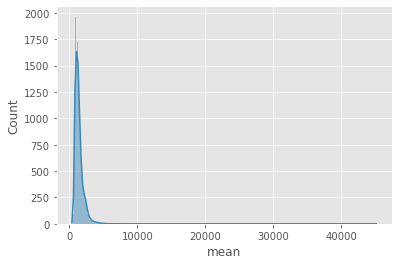

In [117]:
sns.histplot(zri_df_long['mean'],kde = True);

In [118]:
#since the dataset is organized by year and then by region. Linear interpolation for the 
# mean values is a good approach. If the yearly value is missing, then it will interpolate
#from the contigous zip code.
zri_df = zri_df.interpolate(method='linear', axis = 0)

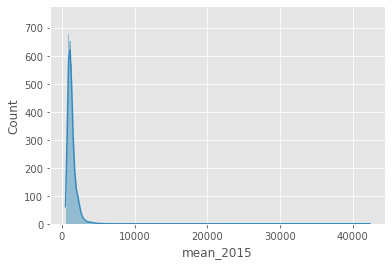

In [119]:
sns.histplot(zri_df['mean_2015'],kde = True);

In [120]:
zri_df['mean_2015'] = np.log(zri_df['mean_2015'])
zri_df['mean_2016'] = np.log(zri_df['mean_2016'])
zri_df['mean_2017'] = np.log(zri_df['mean_2017'])
zri_df['mean_2018'] = np.log(zri_df['mean_2018'])

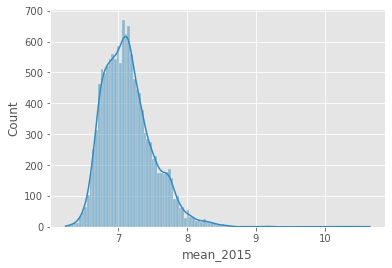

In [121]:
sns.histplot(zri_df['mean_2015'],kde = True);

<AxesSubplot:xlabel='year', ylabel='log_mean_zri'>

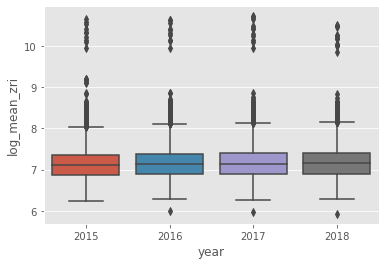

In [122]:
zri_df_long["log_mean_zri"] = np.log(zri_df_long["mean"])

sns.boxplot(x ='year', y = "log_mean_zri", data = zri_df_long)

Identified outliers log(mean_zr) above 9

In [123]:
zri_df = zri_df[(zri_df['mean_2015'] < 9) & (zri_df['mean_2016'] <9) &
               (zri_df['mean_2017']< 9) & (zri_df['mean_2018'] <9) ]

zri_df_long = zri_df_long[zri_df_long['log_mean_zri']< 9]

<AxesSubplot:xlabel='year', ylabel='log_mean_zri'>

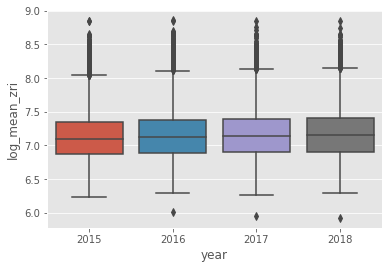

In [124]:
sns.boxplot(x ='year', y = "log_mean_zri", data = zri_df_long)

### ANOVA to see if the zri varies through the years

In [126]:
import scipy.stats as stats

stats.f_oneway(zri_df_long['log_mean_zri'][zri_df_long['year'] == 2015],
               zri_df_long['log_mean_zri'][zri_df_long['year'] == 2016],
               zri_df_long['log_mean_zri'][zri_df_long['year'] == 2017],
               zri_df_long['log_mean_zri'][zri_df_long['year'] == 2018])

F_onewayResult(statistic=35.84172810277422, pvalue=3.950425952425193e-23)

The p value suggests we should reject the null hypothesis. The mean zri varies throught the years

In [197]:
full = pd.merge(zri_df, predictors, how = 'inner', left_on = 'RegionID',
                right_on = 'geo_id')
full.shape
                

(12783, 19)

In [202]:
full.describe()

,mean_2015,mean_2016,mean_2017,mean_2018,RegionID,geo_id,do_date,median_income,gini_index,percent_income_spent_on_rent,unemployed_pop,poverty_rate,hispanic_pop_perc,black_pop_perc,zip_code,pop_density,water_land_ratio
count,12783.000000,12783.000000,12783.000000,12783.000000,12783.000000,12783.000000,1.278300e+04,11872.000000,12441.000000,10445.000000,12783.000000,12605.000000,12673.000000,12673.000000,12765.000000,12765.000000,12765.000000
mean,7.157579,7.182420,7.192192,7.200891,77469.981929,77469.981929,2.012202e+07,53879.345687,0.416124,28.444232,381.918485,0.159644,14.448318,5.814747,77469.068860,0.000452,0.034962
std,0.361752,0.371172,0.371390,0.370140,12930.730825,12930.730825,8.166102e+03,22727.239450,0.075985,8.137241,695.398944,0.121321,21.406536,13.726156,12932.827016,0.001241,0.152659
min,6.235658,6.006353,5.959458,5.924256,58201.000000,58201.000000,2.011202e+07,2499.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,58201.000000,0.000000,0.000000
25%,6.885424,6.900143,6.905984,6.910086,66510.000000,66510.000000,2.011202e+07,39871.000000,0.377700,23.300000,11.000000,0.078845,1.179941,0.000000,66507.000000,0.000003,0.000584
50%,7.110220,7.139904,7.149917,7.161383,75173.000000,75173.000000,2.012202e+07,49308.000000,0.419400,28.200000,60.000000,0.137555,5.242464,0.615088,75173.000000,0.000014,0.004451
75%,7.364060,7.402452,7.418781,7.429384,90067.000000,90067.000000,2.013202e+07,62001.500000,0.459100,32.900000,460.000000,0.210110,17.133956,4.199364,90095.000000,0.000209,0.018170
max,8.847139,8.847216,8.763729,8.840884,99929.000000,99929.000000,2.013202e+07,250001.000000,0.795900,50.000000,7637.000000,1.000000,100.000000,100.000000,99929.000000,0.021279,5.256364


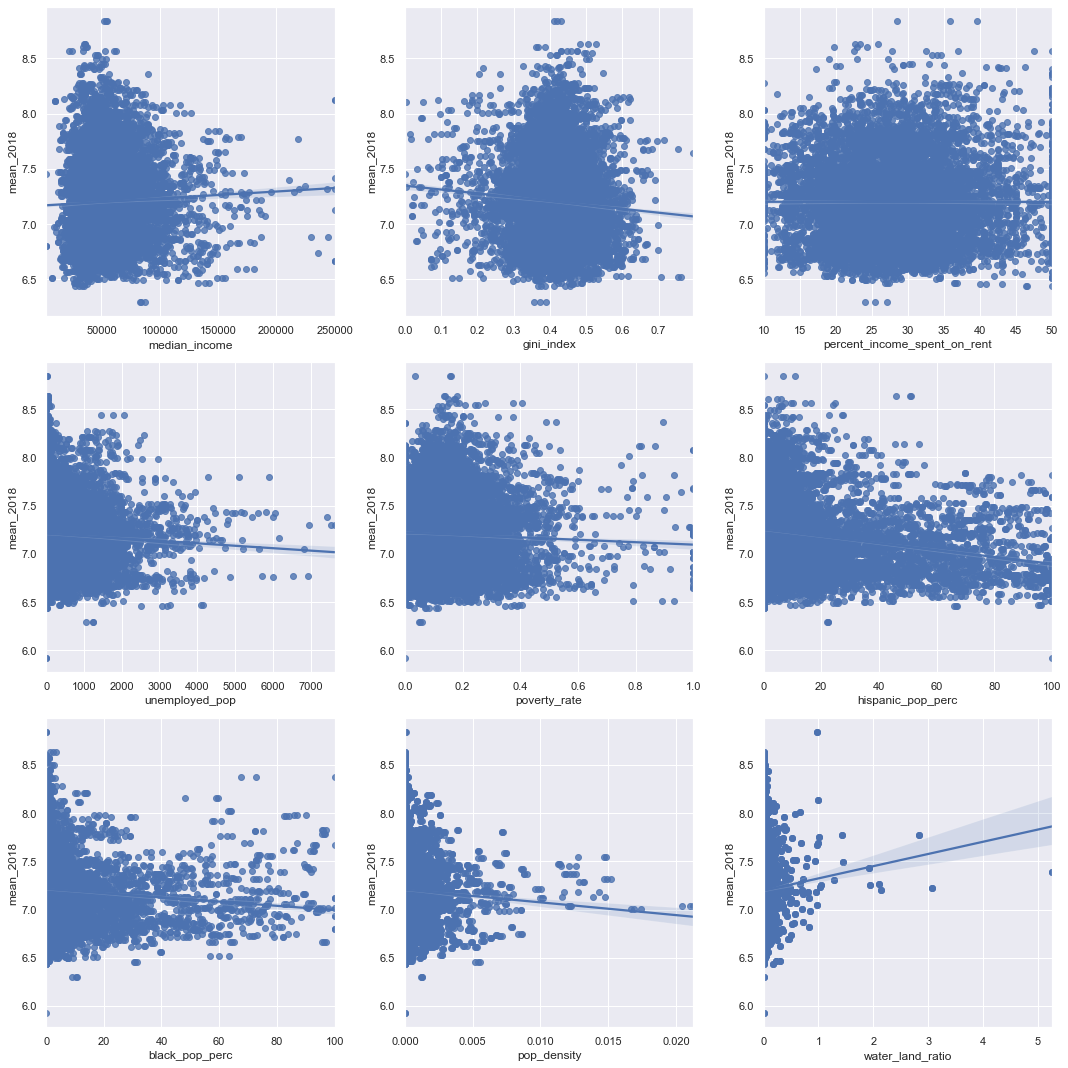

In [203]:
sns.set_theme(color_codes=True)
f, axes = plt.subplots(3, 3, figsize=(15,15))

sns.regplot( x= "median_income", y = 'mean_2018', data=full,  ax=axes[0,0])
sns.regplot( x= "gini_index",y = 'mean_2018', data=full,  ax=axes[0,1])
sns.regplot( x= "percent_income_spent_on_rent", y = 'mean_2018', data=full,  ax=axes[0,2])
sns.regplot( x= "unemployed_pop", y = 'mean_2018', data=full,  ax=axes[1,0])
sns.regplot( x= "poverty_rate", y = 'mean_2018',data=full,  ax=axes[1,1])
sns.regplot( x= "hispanic_pop_perc", y = 'mean_2018',data=full,  ax=axes[1,2])
sns.regplot( x= "black_pop_perc", y = 'mean_2018',data=full,  ax=axes[2,0])
sns.regplot( x= "pop_density", y = 'mean_2018',data=full,  ax=axes[2,1])
sns.regplot( x= "water_land_ratio", y = 'mean_2018',data=full,  ax=axes[2,2])
plt.tight_layout();

In [269]:
full_trans = full.copy()
right_skewed = ["median_income", "unemployed_pop", "poverty_rate", "hispanic_pop_perc",
               "black_pop_perc", "pop_density", "water_land_ratio", 'mean_2015',
               'mean_2016', 'mean_2017']

for col in right_skewed:
    min_ = full_trans[full_trans[col]>0][col].min()
    full_trans[col] = full_trans[col].replace( 0, min_)
    full_trans[col] = np.log(full_trans[col])


In [270]:
full_trans.head()

,mean_2015,mean_2016,mean_2017,mean_2018,RegionID,City,State,geo_id,do_date,median_income,gini_index,percent_income_spent_on_rent,unemployed_pop,poverty_rate,hispanic_pop_perc,black_pop_perc,zip_code,pop_density,water_land_ratio
0,2.033133,2.037358,2.036551,7.650205,84654,Chicago,IL,84654,20112015,10.750235,0.4340,29.3,3.970292,-1.799866,2.019634,-4.778535,84654.0,-12.408093,-7.116703
1,2.033133,2.037358,2.036551,7.650205,84654,Chicago,IL,84654,20122016,10.841109,0.3717,19.2,4.369448,-1.993309,1.325387,-4.778535,84654.0,-12.386792,-7.116703
2,2.033133,2.037358,2.036551,7.650205,84654,Chicago,IL,84654,20132017,10.773734,0.3933,31.1,4.532599,-1.870091,1.426738,-4.778535,84654.0,-12.392832,-7.116703
3,2.126277,2.126225,2.116792,8.129529,61616,New York,NY,61616,20112015,10.768485,0.4234,22.3,5.093750,-2.200836,0.164011,1.838868,61616.0,-6.982047,-2.883529
4,2.126277,2.126225,2.116792,8.129529,61616,New York,NY,61616,20122016,10.752056,0.4313,23.2,4.912655,-2.057873,0.435093,1.596226,61616.0,-6.983209,-2.883529


In [271]:
full_trans['year'] = np.where(full_trans['do_date'] == 20132017, '2017',
                                 np.where(full_trans['do_date'] == 20112015, '2015', '2016'))
full_trans = full_trans.drop(columns = ['zip_code', 'geo_id','do_date'])

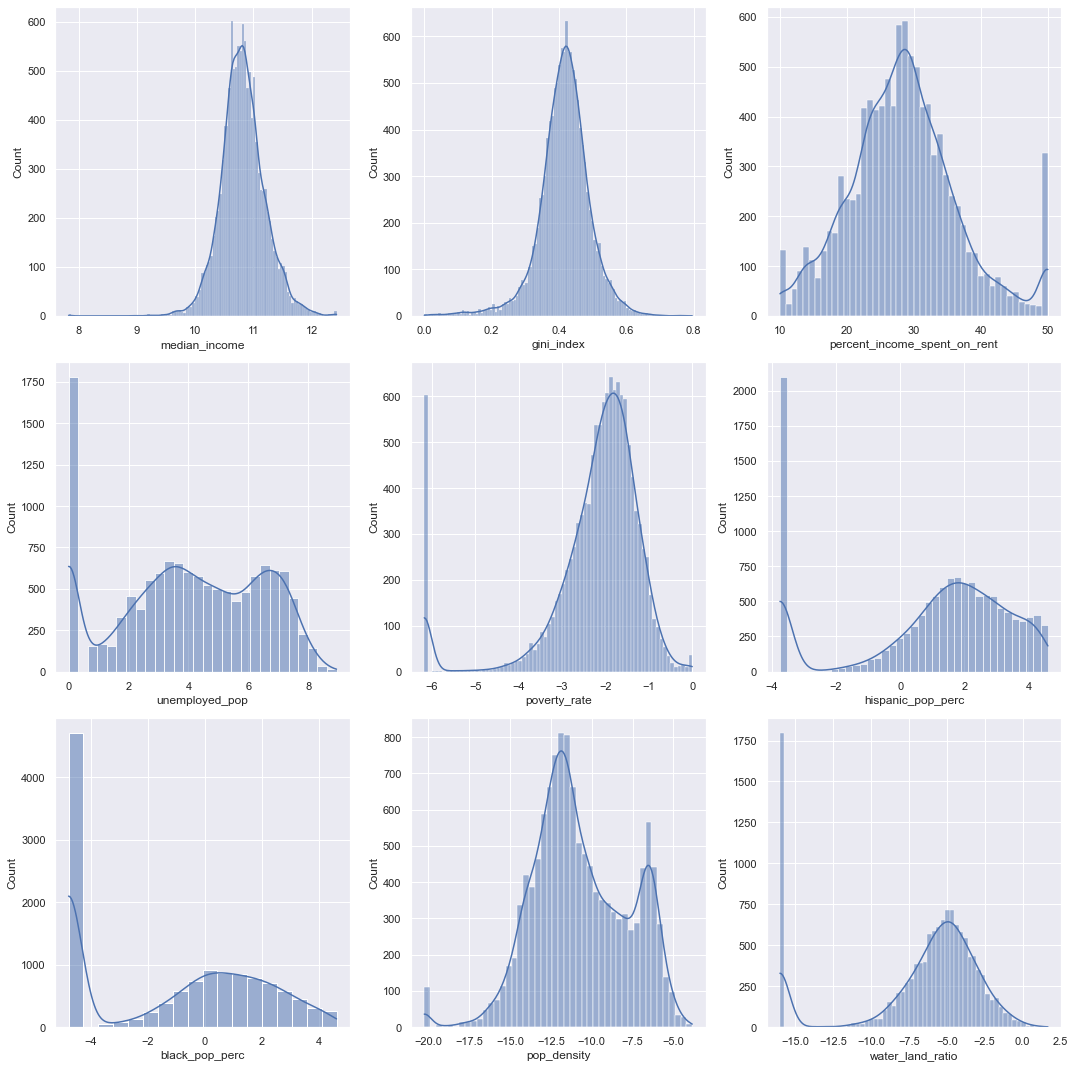

In [242]:
f, axes = plt.subplots(3, 3, figsize=(15,15))

sns.histplot( x= "median_income", data=full_trans,  ax=axes[0,0],kde = True)
sns.histplot( x= "gini_index", data=full_trans,  ax=axes[0,1] ,kde = True)
sns.histplot( x= "percent_income_spent_on_rent", data=full_trans,  ax=axes[0,2],kde = True)
sns.histplot( x= "unemployed_pop", data=full_trans,  ax=axes[1,0],kde = True)
sns.histplot( x= "poverty_rate", data=full_trans,  ax=axes[1,1],kde = True)
sns.histplot( x= "hispanic_pop_perc", data=full_trans,  ax=axes[1,2],kde = True)
sns.histplot( x= "black_pop_perc", data=full_trans,  ax=axes[2,0],kde = True)
sns.histplot( x= "pop_density", data=full_trans,  ax=axes[2,1],kde = True)
sns.histplot( x= "water_land_ratio", data=full_trans,  ax=axes[2,2],kde = True)
plt.tight_layout();

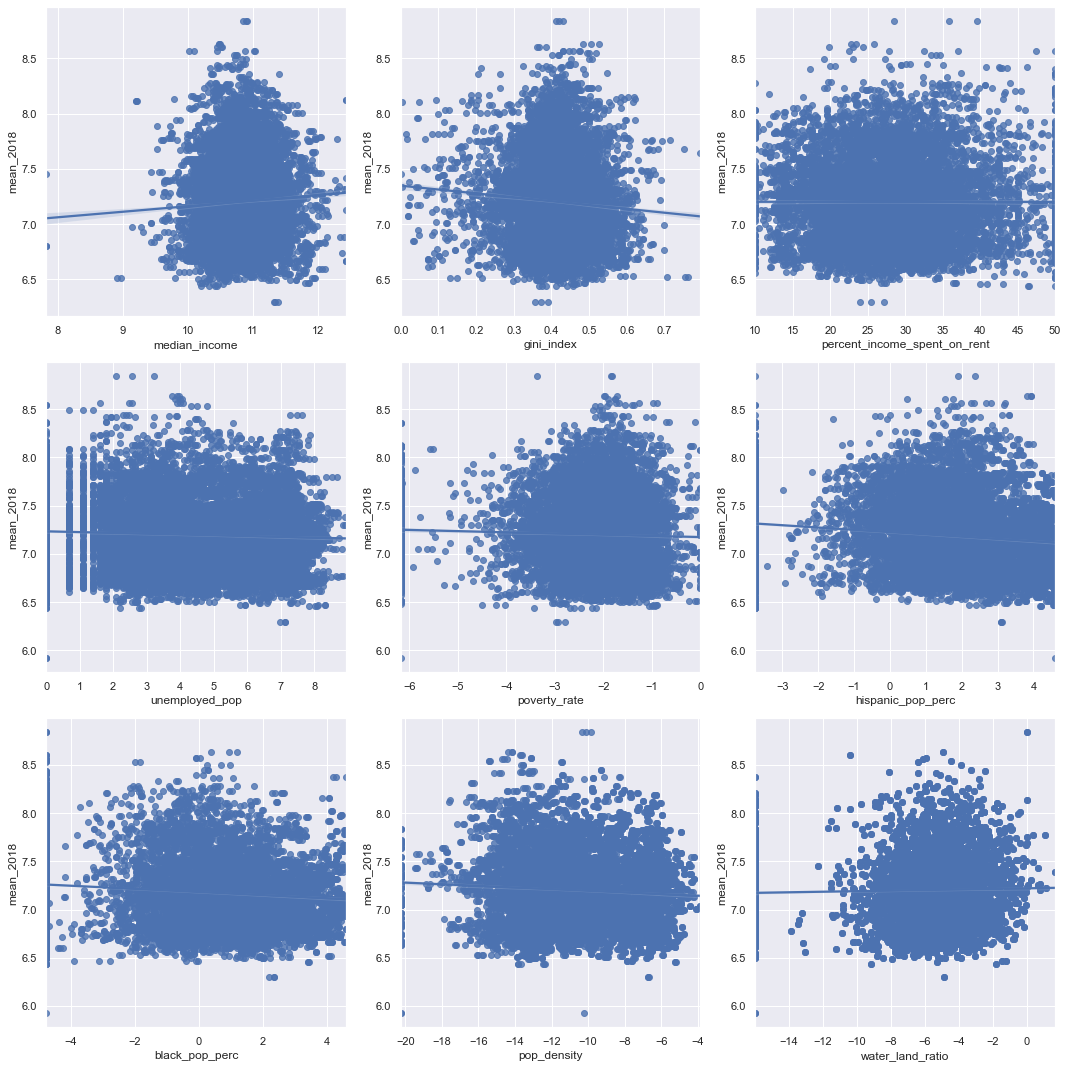

In [237]:
f, axes = plt.subplots(3, 3, figsize=(15,15))

sns.regplot( x= "median_income", y = 'mean_2018', data=full_trans,  ax=axes[0,0])
sns.regplot( x= "gini_index",y = 'mean_2018', data=full_trans,  ax=axes[0,1])
sns.regplot( x= "percent_income_spent_on_rent", y = 'mean_2018', data=full_trans, ax=axes[0,2])
sns.regplot( x= "unemployed_pop", y = 'mean_2018', data=full_trans,  ax=axes[1,0])
sns.regplot( x= "poverty_rate", y = 'mean_2018',data=full_trans,  ax=axes[1,1])
sns.regplot( x= "hispanic_pop_perc", y = 'mean_2018',data=full_trans,  ax=axes[1,2])
sns.regplot( x= "black_pop_perc", y = 'mean_2018',data=full_trans,  ax=axes[2,0])
sns.regplot( x= "pop_density", y = 'mean_2018',data=full_trans,  ax=axes[2,1])
sns.regplot( x= "water_land_ratio", y = 'mean_2018',data=full_trans,  ax=axes[2,2])
plt.tight_layout();

<AxesSubplot:xlabel='mean_2017', ylabel='Count'>

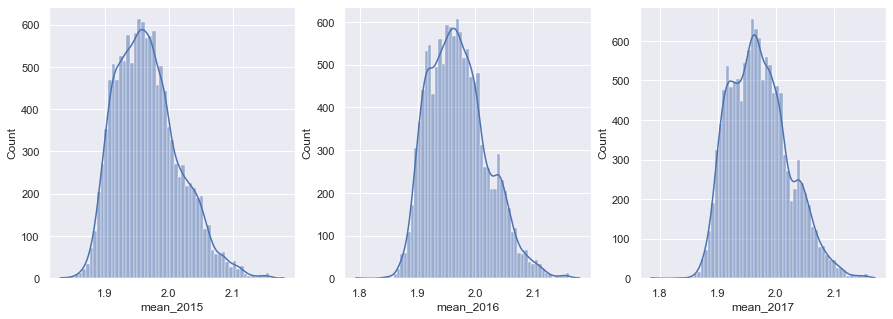

In [243]:
f, axes = plt.subplots(1, 3, figsize=(15,5))

sns.histplot( x= "mean_2015", data=full_trans,  ax=axes[0],kde = True)
sns.histplot( x= "mean_2016", data=full_trans,  ax=axes[1],kde = True)
sns.histplot( x= "mean_2017", data=full_trans,  ax=axes[2],kde = True)

<AxesSubplot:xlabel='mean_2017', ylabel='mean_2018'>

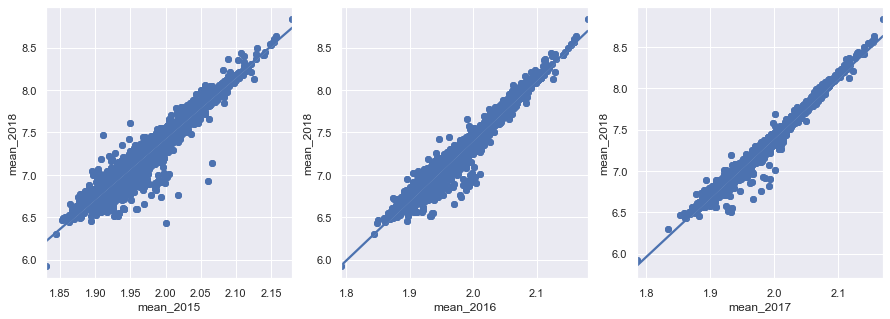

In [245]:
f, axes = plt.subplots(1, 3, figsize=(15,5))

sns.regplot( x= "mean_2015", y = 'mean_2018', data=full_trans,  ax=axes[0])
sns.regplot( x= "mean_2016",y = 'mean_2018', data=full_trans,  ax=axes[1])
sns.regplot( x= "mean_2017", y = 'mean_2018', data=full_trans,  ax=axes[2])

In [272]:
full_trans.isnull().sum()

mean_2015                          0
mean_2016                          0
mean_2017                          0
mean_2018                          0
RegionID                           0
City                               0
State                              0
median_income                    911
gini_index                       342
percent_income_spent_on_rent    2338
unemployed_pop                     0
poverty_rate                     178
hispanic_pop_perc                110
black_pop_perc                   110
pop_density                       18
water_land_ratio                  18
year                               0
dtype: int64

### Imputations

In [273]:
full_trans['percent_income_spent_on_rent'] = full_trans['percent_income_spent_on_rent'
                                              ].fillna(full_trans.groupby(['City', 'year']
                                              )['percent_income_spent_on_rent'
                                               ].transform('median'))
full_trans['percent_income_spent_on_rent'] = full_trans['percent_income_spent_on_rent'
                                              ].fillna(full_trans.groupby(['State', 'year']
                                              )['percent_income_spent_on_rent'
                                               ].transform('median'))

In [278]:
full_trans['pop_density'] = full_trans['pop_density'].fillna(full_trans.groupby(
                            ['City', 'year'])['pop_density'].transform('mean'))
full_trans['pop_density'] = full_trans['pop_density'].fillna(full_trans.groupby(
                            ['State', 'year'])['pop_density'].transform('mean'))

In [280]:
full_trans['water_land_ratio'] = full_trans['water_land_ratio'].fillna(full_trans.groupby(
                            ['City', 'year'])['water_land_ratio'].transform('mean'))
full_trans['water_land_ratio'] = full_trans['water_land_ratio'].fillna(full_trans.groupby(
                            ['State', 'year'])['water_land_ratio'].transform('mean'))

In [284]:
full_trans['black_pop_perc'] = full_trans['black_pop_perc'].fillna(full_trans.groupby(
                            ['City', 'year'])['black_pop_perc'].transform('median'))
full_trans['black_pop_perc'] = full_trans['black_pop_perc'].fillna(full_trans.groupby(
                            ['State', 'year'])['black_pop_perc'].transform('median'))

In [287]:
full_trans['hispanic_pop_perc'] = full_trans['hispanic_pop_perc'].fillna(full_trans.groupby(
                            ['City', 'year'])['hispanic_pop_perc'].transform('median'))
full_trans['hispanic_pop_perc'] = full_trans['hispanic_pop_perc'].fillna(full_trans.groupby(
                            ['State', 'year'])['hispanic_pop_perc'].transform('median'))

In [288]:
full_trans['gini_index'] = full_trans['gini_index'].fillna(full_trans.groupby(
                            ['City', 'year'])['gini_index'].transform('mean'))
full_trans['gini_index'] = full_trans['gini_index'].fillna(full_trans.groupby(
                            ['State', 'year'])['gini_index'].transform('mean'))

In [289]:
full_trans['poverty_rate'] = full_trans['poverty_rate'].fillna(full_trans.groupby(
                            ['City', 'year'])['poverty_rate'].transform('median'))
full_trans['poverty_rate'] = full_trans['poverty_rate'].fillna(full_trans.groupby(
                            ['State', 'year'])['poverty_rate'].transform('median'))

In [290]:
full_trans['median_income'] = full_trans['median_income'].fillna(full_trans.groupby(
                            ['City', 'year'])['median_income'].transform('median'))
full_trans['median_income'] = full_trans['median_income'].fillna(full_trans.groupby(
                            ['State', 'year'])['median_income'].transform('median'))

In [291]:
nulls = full_trans.isnull().sum(axis = 0)
nulls[nulls>1].sort_values()

Series([], dtype: int64)

# Base model

In [342]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Xbase = full_trans[['mean_2015']]
y = full_trans['mean_2018']

XtrainB, XtestB, ytrainB, ytestB = train_test_split(Xbase,y)
base_ols = LinearRegression()
base_ols.fit(XtrainB,ytrainB)

print(f'Linear regression training score: {base_ols.score(XtrainB,ytrainB)}')
print(f'Linear regression testing score: {base_ols.score(XtestB,ytestB)}')

y_pred = base_ols.predict(XtestB)
RMSE = mean_squared_error(ytestB,y_pred,squared = False)
print(f'Linear regression RMSE: {RMSE}')

Linear regression training score: 0.9385923328775482
Linear regression testing score: 0.937918909169747
Linear regression RMSE: 0.09323078688722815


Try to predict 2018 zri based on the features from 2015

In [345]:
from sklearn.preprocessing import StandardScaler

X = full_trans[full_trans['year'] == '2015']
X = X[["median_income", "unemployed_pop", "poverty_rate", "hispanic_pop_perc",
                         "black_pop_perc", "pop_density", "water_land_ratio", "gini_index",
                         "percent_income_spent_on_rent"]]
y = full_trans[full_trans['year'] == '2015']
y = y['mean_2018']

XtrainP, XtestP, ytrainP, ytestP = train_test_split(X, y)

scaler = StandardScaler()


# Fix the scale model using the train set
scaler.fit(XtrainP)
XtrainP_scaled = scaler.transform(XtrainP)
XtestP_scaled  = scaler.transform(XtestP)


ols = LinearRegression()
ols.fit(XtrainP_scaled,ytrainP)

print(f'Linear regression training score: {ols.score(XtrainP_scaled,ytrainP)}')
print(f'Linear regression testing score: {ols.score(XtestP_scaled,ytestP)}')

y_pred = ols.predict(XtestP_scaled)
RMSE = mean_squared_error(ytest,y_pred,squared = False)
print(f'Linear regression RMSE: {RMSE}')

Linear regression training score: 0.04682576701148322
Linear regression testing score: 0.04306773244025752
Linear regression RMSE: 0.3769565688208224


In [328]:
X = full_trans[full_trans['year'] == '2015']
X = X[["mean_2015","median_income", "unemployed_pop", "poverty_rate", "hispanic_pop_perc",
                         "black_pop_perc", "pop_density", "water_land_ratio", "gini_index",
                         "percent_income_spent_on_rent"]]
y = full_trans[full_trans['year'] == '2015']
y = y['mean_2018']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

scaler = StandardScaler()


# Fix the scale model using the train set
scaler.fit(Xtrain)
Xtrain_scaled = scaler.transform(Xtrain)
Xtest_scaled  = scaler.transform(Xtest)


ols2 = LinearRegression()
ols2.fit(Xtrain_scaled,ytrain)

print(f'Linear regression training score: {ols2.score(Xtrain_scaled,ytrain)}')
print(f'Linear regression testing score: {ols2.score(Xtest_scaled,ytest)}')

y_pred = ols2.predict(Xtest_scaled)
RMSE = mean_squared_error(ytest,y_pred,squared = False)
print(f'Linear regression RMSE: {RMSE}')

Linear regression training score: 0.9382081856274952
Linear regression testing score: 0.9410829266347788
Linear regression RMSE: 0.09022775122963314


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import  GridSearchCV, KFold

In [343]:
rfrBase = RandomForestRegressor()
rfrBase.fit(XtrainB, np.ravel(ytrainB))
print(f'RF regression training score: {rfrBase.score(XtrainB, np.ravel(ytrainB))}')
print(f'RF regression testing score: {rfrBase.score(XtestB, ytestB)}')

RF regression training score: 0.995425973102349
RF regression testing score: 0.9838956345192496


Adding more variables to the base RF model

In [331]:
rfr = RandomForestRegressor()
rfr.fit(Xtrain_scaled, np.ravel(ytrain))
print(f'RF regression training score: {rfr.score(Xtrain_scaled, np.ravel(ytrain))}')
print(f'RF regression testing score: {rfr.score(Xtest_scaled, ytest)}')

RF regression training score: 0.9908175621994745
RF regression testing score: 0.9382944465744781


In [332]:
#parameters grid
params = {'ccp_alpha':[0,0.5], #lets decrease the size of each tree
         'n_estimators': [10,50,100],
         'min_samples_leaf':[1,2,5,10]}
cv = KFold(n_splits = 5, shuffle= True)

grid = GridSearchCV(estimator = rfr,
                   param_grid = params,
                   cv = cv,
                   return_train_score = True)

grid.fit(Xtrain_scaled, np.ravel(ytrain))

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'ccp_alpha': [0, 0.5],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'n_estimators': [10, 50, 100]},
             return_train_score=True)

In [333]:
grid.best_params_

{'ccp_alpha': 0, 'min_samples_leaf': 5, 'n_estimators': 100}

In [337]:
best_rf = grid.best_estimator_
print(f'RF best regression training score: {best_rf.score(Xtrain_scaled, ytrain)}')
print(f'RF best regression training score: {best_rf.score(Xtest_scaled, ytest)}')

RF best regression training score: 0.968754475616263
RF best regression training score: 0.9413017959606307


Using predictors minus median_2015

In [347]:
rfrP = RandomForestRegressor()
rfrP.set_params(min_samples_leaf = 5, n_estimators = 100)
rfr.fit(XtrainP_scaled, np.ravel(ytrainP))
print(f'RF regression training score: {rfr.score(XtrainP_scaled, np.ravel(ytrainP))}')
print(f'RF regression testing score: {rfr.score(XtestP_scaled, ytestP)}')

RF regression training score: 0.8714832971990446
RF regression testing score: 0.10929544506615718
